#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

#### parameters to set

In [2]:
n_series = 6
n_timesteps = 8*24*3600 # 8 days

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

#### generate normal data

In [3]:
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df[s]=pd.Series(v)
df['Flag']=False
#df.head()

#### generate anomalies

In [4]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = (n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    for s in affects:
        df.loc[start:end,s] = df.loc[start:end,s] + random.random() * 0.3
    if len(affects)>1:
        df.loc[start:end,"Flag"]=True
        

#### enforce range

In [5]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

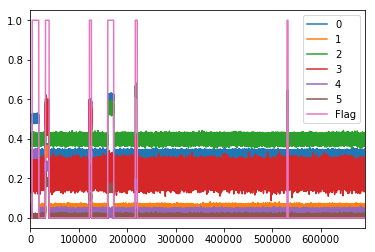

In [6]:
df.plot()

#### running BDT

In [7]:
clf = AdaBoostClassifier(n_estimators=100)
# y=df.Flag
# X=df.loc[:,range(n_series)]
# scores = cross_val_score(clf, X, y)
# print(scores)

#### separate data into Reference and Subject

In [8]:
reference = df[:n_timesteps/2] #first 4 days
X_ref = reference.loc[:, range(n_series)]
y_ref = reference.Flag
subject = df[n_timesteps/2:] #remaining 4 days
X_sub = subject.loc[:, range(n_series)]
y_sub = subject.Flag

#### separate Reference and Subject into Train and Test

In [9]:
refTrainSize = reference.shape[0] * 0.7
X_ref_train = X_ref.loc[:refTrainSize, range(n_series)]
X_ref_test  = X_ref.loc[refTrainSize:, range(n_series)]
y_ref_train = y_ref.loc[:refTrainSize]
y_ref_test  = y_ref.loc[refTrainSize:]

subTrainSize = subject.shape[0] * 0.7
X_sub_train = subject.loc[:subTrainSize, range(n_series)]
X_sub_test  = subject.loc[subTrainSize:, range(n_series)]
y_sub_train = y_sub.loc[:subTrainSize]
y_sub_test  = y_sub.loc[subTrainSize:]

#### Combine reference and subject train and test datasets

In [10]:
X_train_frames = [X_ref_train, X_sub_train]
X_train = pd.concat(X_train_frames)
y_train_frames = [y_ref_train, y_sub_train]
y_train = pd.concat(y_train_frames)

X_test_frames = [X_ref_test, X_sub_test]
X_test = pd.concat(X_test_frames)
y_test_frames = [y_ref_test, y_sub_test]
y_test = pd.concat(y_test_frames)

#### Train model using the combined train data

In [11]:
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

#### Predict using the combined test data

In [12]:
y_predict = clf.predict(X_test)

#### Calculate AUC

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# convert False and True to 0 and 1
lb = LabelBinarizer()
y_test_transformed = lb.fit_transform(y_test)
y_predict_transformed = lb.fit_transform(y_predict)
fpr, tpr, thresholds = roc_curve(y_test_transformed, y_predict_transformed)
auc_score = auc(fpr, tpr)
print auc_score

1.0


#### Graph

In [16]:
def Adaboost(X_Train,X_Test,y_Train, y_Test):
    clf = AdaBoostClassifier(n_estimators=100)
    #creates a boosted decision tree
    #scores = cross_val_score(clf, iris.data, iris.target)
    #scores.mean()  
    clf.fit(X_Train,y_Train)
    #trains the model
    
    y_predict = clf.predict(X_Test)
    
    lb = LabelBinarizer()
    y_test_transformed = lb.fit_transform(y_Test)
    y_predict_transformed = lb.fit_transform(y_predict)

    fpr, tpr, _ = roc_curve(y_test_transformed, y_predict_transformed)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    return clf

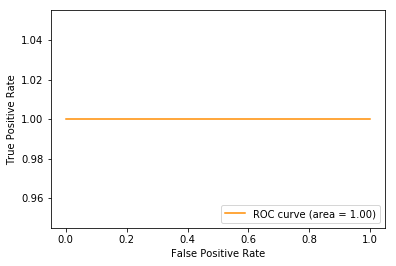

In [17]:
clf=Adaboost(X_train, X_test, y_train, y_test)